In [1]:
%matplotlib notebook

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import celerite
from celerite import terms
import emcee
import corner
from scipy import signal
from scipy import stats
from scipy.optimize import minimize
from scipy.optimize import curve_fit
from IPython.display import display, Math, Image
import os
from astropy.io import fits
import pandas as pd
import glob
from astropy.io import ascii
from astropy.timeseries import LombScargle
from lmfit import minimize, Parameters

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:72: UserWarning: h5py is running against HDF5 1.10.2 when it was built against 1.10.3, this may cause problems
  '{0}.{1}.{2}'.format(*version.hdf5_built_version_tuple)


In [3]:
dir = os.getcwd()
dir

'C:\\Users\\Marc\\Documents\\repo\\stage_m2\\src'

In [4]:
par_dir = os.path.dirname(dir)
par_dir

'C:\\Users\\Marc\\Documents\\repo\\stage_m2'

In [5]:
### Définition de la likelihood ###
def log_likelihood(params,gp,time,flux):
    gp.set_parameter_vector(params)
    ll = gp.log_likelihood(flux)
    return ll if np.isfinite(ll) else -np.inf

### Définition du prior (uniforme) ###
def log_prior(params):
    ### params[0] = Log S0, params[1] = Log Q, params[2] = log w0, params[3] = jitter
    if ((-30 < params[0] < 30) and (-10 < params[1] < 10) and (5 < params[2] < 7)):
        return 0
    return -np.inf

### Définition du posterior ###
def log_probability(params,gp,time,flux):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params,gp,time,flux) if np.isfinite(lp) else -np.inf

### MCMC ###
def run_mcmc(time,flux,gp,mcmc_params) :
    nwalkers = mcmc_params[0]
    nburnsteps = mcmc_params[1]
    nprogsteps = mcmc_params[2]
    
    initial = gp.get_parameter_vector()
    ndim = len(initial)
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability,args=(gp,time,flux))

    print("Running burn-in...")
    p0 = initial + 1e-8 * np.random.randn(nwalkers, ndim)
    p0, lp, _ = sampler.run_mcmc(p0, nburnsteps,progress=True)

    print("Running production...")
    sampler.reset()
    sampler.run_mcmc(p0, nprogsteps,progress=True)
    print("Finished")
    
    likelihood = gp.log_likelihood(flux)
    af = sampler.acceptance_fraction
    
    print("Mean acceptance fraction:", np.mean(af))
    print("parameter_dict:\n{0}\n".format(gp.get_parameter_dict()))
    print("Final MCMC log likelihood: {0}".format(gp.log_likelihood(flux)))
    return(sampler,likelihood)

In [6]:
### Fonction création de l'objet GP
def gp_building(param,time,flux,error) :
    bounds1 = dict(log_S0= (None,None), log_Q = (-10,10), log_omega0 = (5,7)) ### Bornes des hyperparamètres du SHO    
    bounds2 = dict(log_sigma= (None,None)) ## Bornes du jitter
    kernel1 = terms.SHOTerm(log_S0=param[0], log_Q=param[1], log_omega0=param[2],bounds=bounds1) ### Choix de la fonction de covariance, ici SHO
    kernel2 = terms.JitterTerm(log_sigma=param[3],bounds=bounds2)
    kernel = kernel1 + kernel2
    
    gp = celerite.GP(kernel,mean=np.mean(flux)) ### Création du GP
    gp.compute(time,yerr=error) ### Création de la matrice de covariance, à faire obligatoirement !
 
    print("Initial log likelihood: {0}".format(gp.log_likelihood(flux)))
    print("parameter_dict:\n{0}\n".format(gp.get_parameter_dict()))
    
    return gp

In [7]:
### Utile pour les prédictions, Faire une prédiction avec une matrice de covariance de n x n termes peut être très long
### en coûteux en mémoire, ici on split la matrice pour aller plus vite.

def mean_building (gp,time,flux) :
    print(len(time))
    mean = np.array([])
    std = np.array([])
    t = [i*1000 for i in range(0,1000)]
    for it in range(len(t)+1): ### Split des données en groupes de 1000 observations
        if ((np.abs(np.argmax(time) - t[it])) < (t[it+1] - t[it])) : 
            x = time[t[it]:np.argmax(time)+1]
            print(t[it]," : ",np.argmax(time)+1)
            ### Pour faire une prédiciton (gp.predict), il faut avoir fait gp.compute en premier lieu.
            ### gp.predict a besoin des mêmes observations que celles données à gp.compute (flux), x correspond aux temps choisis pour la prédiction
            pred_mean, pred_var = gp.predict(flux, x, return_var=True) ### Prédiction, on récupère la fonction moyenne et la variance
            pred_std = np.sqrt(pred_var) ### Déviation standard de la prédiction
            std = np.append(std,pred_std)  
            mean = np.append(mean,pred_mean) 
            break
        x = time[t[it]:t[it+1]]
        print(t[it],":",t[it+1])
        pred_mean, pred_var = gp.predict(flux, x, return_var=True)
        pred_std = np.sqrt(pred_var)
        std = np.append(std,pred_std)
        mean = np.append(mean,pred_mean)
    return mean,std ### On retourne les résultats des prédictions

In [8]:
### Fonction pour récupérer les infos des .fits des secteurs TESS
def write_photometry_file (photometry_names,photometry_fits,normalize) :
    
    ### photometry_names = noms des photométries à tester
    ### photometry_fits = noms des fichiers fits pour chaque photométrie
    ### normalize = utilisation de la photométrie normalisée ou brute
    
    for name,fit in zip(photometry_names,photometry_fits) :
        
        if name != "TESS_ALL" :
            
            ### Création d'un fichier txt pour les data des secteurs bruts et normalisés
            if normalize == True :
                file_output = open(par_dir+"/data/Photometry/TESS_data/"+ name +"_norm_data.txt","w")

            else :
                file_output = open(par_dir+"/data/Photometry/TESS_data/"+ name +"_data.txt","w")
            
            print(name)

            ### Lecture du fichier fits correspond au nom du secteur
            hdul = fits.open(par_dir + fit)
            data = hdul[1].data
            time = data['TIME']
            flux = data['PDCSAP_FLUX']
            flux_error = data['PDCSAP_FLUX_ERR']
            index = np.argwhere((~np.isnan(flux)) & (data["QUALITY"] == 0)) ### On retire les données avec des nan et des flags != 0
            time = np.ndarray.flatten(time[index])           
                
            if normalize == True : ### Normalisation
                flux_error = np.ndarray.flatten(flux_error[index])/np.median(flux[index]) 
                flux = np.ndarray.flatten(flux[index])/np.median(flux[index])
            
            else :
                flux_error = np.ndarray.flatten(flux_error[index])
                flux = np.ndarray.flatten(flux[index]) 
            
            output_data = np.column_stack((time,flux,flux_error))        
            np.savetxt(file_output,output_data,header="Time Flux Flux Error",delimiter=' ') ### Ecriture du fichier
            file_output.close()
            
        ### Assemblage des secteurs pour la photométrie finale normalisée, même procédé qu'au-dessus  
        elif ((name == "TESS_ALL") & (normalize == True)) :
            file_output = open(par_dir+"/data/Photometry/TESS_data/"+ name +"_norm_data.txt","w")
            
            fits_files = glob.glob(par_dir+"/data/*.fits")
            time = np.array([])
            flux = np.array([])
            flux_error = np.array([])
            for fits_file in fits_files[1:] :
                print(fits_file)
                hdul = fits.open(fits_file)
                data = hdul[1].data
                fits_time = data['TIME']
                fits_flux = data['PDCSAP_FLUX']
                fits_flux_error = data['PDCSAP_FLUX_ERR']
                index = np.argwhere((~np.isnan(fits_flux)) & (data["QUALITY"] == 0))

                fits_time = np.ndarray.flatten(fits_time[index])
                fits_flux_error = np.ndarray.flatten(fits_flux_error[index])/np.nanmedian(fits_flux)
                fits_flux = np.ndarray.flatten(fits_flux[index])/np.nanmedian(fits_flux)

                time = np.append(time,fits_time)
                flux = np.append(flux,fits_flux)
                flux_error = np.append(flux_error,fits_flux_error)
                
            output_data = np.column_stack((time,flux,flux_error))        
            np.savetxt(file_output,output_data,header="Time Flux Flux Error",delimiter=' ')
            file_output.close()

In [27]:
### Fonction pour obtenir les postérieurs des hyperparamètres (HP) du GP entraîné par une photométrie
def GP_photometry (photometry_names,normalize,initial_params,mcmc_params) :
    
    ### photometry_names = noms des photométries à tester
    ### normalize = utilisation de la photométrie normalisée ou brute
    ### initial_params = valeurs initiales des hyperparamètres du GP
    ### mcmc_params = [nb de walkers, nb de burn-in steps, nb de production steps]
    
    for name in photometry_names :
        
        ### Récupération des données des secteurs
        if ((normalize == False) & (name == "TESS_ALL")) :
            break
        
        elif normalize == True :
            print(name)
            data = np.loadtxt(par_dir + "/data/Photometry/TESS_data/" + name + "_norm_data.txt",usecols=(0,1,2),skiprows = 1, delimiter = ' ')
        
        else : 
            print(name)
            data = np.loadtxt(par_dir + "/data/Photometry/TESS_data/" + name + "_data.txt",usecols=(0,1,2),skiprows = 1, delimiter = ' ')
          
        time = data[:,0]
        flux = data[:,1]
        flux_error = data[:,2]
        ### Création du GP avec les valeurs initiales des HP + data photométrie
        gp = gp_building(initial_params,time,flux,flux_error)
        
        
        
        ### Minimize ###
        ### Obtention des maxima a posteriori, recommandé par celerite.
#         def neg_log_like(params, y, gp):
#             gp.set_parameter_vector(params)
#             return -gp.log_likelihood(y)
#         ### Les HP sont mis en argument de la minimisation
#         p0 = gp.get_parameter_vector() ### gp.get_parameter_vector() pour obtenir les valeurs des HP du GP
#         bounds = gp.get_parameter_bounds() ### gp.get_parameter_bounds() pour obtenir les bornes des HP du GP
#         print(p0,bounds)
#         # run optimization:
#         results = minimize(neg_log_like, p0, method='L-BFGS-B',bounds=bounds,args=(flux, gp))
#         print(results)
#         print("Final log-likelihood: {0}".format(-results.fun))
#         print(np.exp(results.x))
#         print("Parameters: {0}".format(gp.get_parameter_dict()))
#         ### les maxima sont mis comme HP du GP
#         ### set_parameter_vector(X) définir X (X vecteur de longueur le nombre de HP du GP) comme HP du GP
#         gp.set_parameter_vector(results.x) 
        
        ### MCMC
        sampler,likelihood = run_mcmc(time,flux,gp,mcmc_params)

        ## Posteriors ###
        flat_samples = sampler.get_chain(discard = 5000,thin = 1,flat=True) ### On récupère les samples, on jette ceux du burn-in
        labels = ["ln S0","ln Q","ln $\omega_0$ [day^{-1}]","jitter"] ### Labels pour le corner plot

        posteriors = np.array([]) 
        posteriors_errors = np.array([])
        output_posteriors = np.array([])      
        
        for i in range(flat_samples.shape[1]):

            mcmc = np.percentile(flat_samples[:, i], [16, 50, 84]) ### On récupère les valeurs de 1 sigma 
            value = np.percentile(flat_samples[:, i], [50]) ### On récupère la mediane
            q = np.diff(mcmc) ### Incertitude
            txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
            txt = txt.format(mcmc[1], q[0], q[1], labels[i])
            display(Math(txt))
            posteriors = np.append(posteriors,value) ### On stocke la médiane de chaque hyperparamètre
            posteriors_errors = np.append(posteriors_errors,q) ### On stocke les incertitudes de chaque hyperparamètre
        
        ### Création d'un fichier pour écrire les distributions des HP du GP pour chaque photométrie, brute ou normalisée
        if normalize == True :
            file = open(par_dir + "/data/Photometry/GP_photometry_data/" + name + "_norm_photometry_posteriors.txt","w")
        
        else : 
            file = open(par_dir + "/data/Photometry/GP_photometry_data/" + name + "_photometry_posteriors.txt","w")
        
        output_names = ["LogS0", "LogQ", "Logw0", "Jitter",
                        "Inc-S0", "Inc+S0", "Inc-Q", "Inc+Q", "Inc-w0", "Inc+w0", "Inc-Jitter", "Inc+Jitter", "Likelihood"]
        output_posteriors = np.append(output_posteriors,posteriors)
        output_posteriors = np.append(output_posteriors,posteriors_errors)
        output_posteriors = np.append(output_posteriors,likelihood)
        output_data = np.column_stack((output_names,output_posteriors))

        np.savetxt(file,output_data,fmt='%10s',delimiter=' ')
        file.close()
        
        ### Corner plots
        if normalize == True :

            fig = corner.corner(flat_samples, labels=labels, truths=[None,None,np.log(2*np.pi*24*60/30.4),None],quantiles=[0.5],show_titles=True,title_fmt = '.3f',levels=(0.68,0.95,0.997))
            axes = np.array(fig.axes).reshape((flat_samples.shape[1], flat_samples.shape[1]))
            for i in range(flat_samples.shape[1]):
                ax = axes[i,i]
                ax.fill_between((posteriors[i] - posteriors_errors[i*2],posteriors[i] + posteriors_errors[i*2+1]),len(flat_samples), color='gray', alpha=0.3, edgecolor="none",interpolate=True)
            plt.savefig(par_dir + "/plots/%s/GP_photometry/Posteriors_MCMC_%s_norm.pdf"%(name,name),bbox_inches='tight')
            plt.show() 

        else :
            fig = corner.corner(flat_samples, labels=labels, truths=[None,None,np.log(2*np.pi*24*60/30.4),None],quantiles=[0.5],show_titles=True,title_fmt = '.3f',levels=(0.68,0.95,0.997))
            axes = np.array(fig.axes).reshape((flat_samples.shape[1], flat_samples.shape[1]))
            for i in range(flat_samples.shape[1]):
                ax = axes[i, i]
                ax.fill_between([posteriors[i] - posteriors_errors[i*2],posteriors[i] + posteriors_errors[i*2+1]],len(flat_samples), color='gray', alpha=0.3, edgecolor="none",interpolate=True)
            plt.savefig(par_dir + "/plots/%s/GP_photometry/Posteriors_MCMC_%s.pdf"%(name,name),bbox_inches='tight')
            plt.show()
                
                

In [10]:
### Calcul des résidus et des périodogrammes
def photometry_periodo_residus (photometry_names,time_binning,periods,normalize) :
    
    ### photometry_names = noms des photométries à tester
    ### time_binning = fenêtre de temps choisi pour le binning
    ### periods = périodes pour le périodogramme
    ### normalize = utilisation de la photométrie normalisée ou brute
    
    for name in photometry_names :

        if ((normalize == False) & (name == "TESS_ALL")) :
            break
        
        ### On récupère les données de la photométrie + posterieurs HP de la photométrie
        elif normalize == True :
            print(name)
            photo_data = np.loadtxt(par_dir + "/data/Photometry/TESS_data/" + name + "_norm_data.txt",usecols=(0,1,2),skiprows = 1, delimiter = ' ')
            gp_photo_data = np.genfromtxt(par_dir + "/data/Photometry/GP_photometry_data/" + name + "_norm_photometry_posteriors.txt",usecols=1, delimiter = ' ')
            
        else : 
            print(name)
            photo_data = np.loadtxt(par_dir + "/data/Photometry/TESS_data/" + name + "_data.txt",usecols=(0,1,2),skiprows = 1, delimiter = ' ')
            gp_photo_data = np.genfromtxt(par_dir + "/data/Photometry/GP_photometry_data/" + name + "_photometry_posteriors.txt",usecols=1, delimiter = ' ')
            
        time = photo_data[:,0]
        flux = photo_data[:,1]
        flux_error = photo_data[:,2]
        posteriors = gp_photo_data[:4]
        
        mean =np.array([])
        std = np.array([])
        gp = gp_building(posteriors,time,flux,flux_error) ### On construit le GP avec les postérieurs des HP
        limits = np.array([1437.82566, 1450.20, 1451.547, 1464.40056, 1468.21262, 1477.025, 1478.1, 1490.05, 1491.62553,
                           1503.04, 1504.68, 1516.09, 2174.21898, 2185.94, 2186.938, 2200.23147, 2201.72730, 2213.87, 
                           2215.42, 2227.575, 2228.74533, 2240.91,2241.98, 2254.0676]) ### Limites des secteurs
        
        for j in range(np.int(len(limits)/2)) :
            index = np.ndarray.flatten(np.argwhere((time<limits[j*2+1])&(time>limits[j*2])))
            pred_mean,pred_std = mean_building(gp,time[index],flux) ### Prédictions sur l'intervalle de temps demandé
            std = np.append(std,pred_std)
            mean = np.append(mean,pred_mean)
            
        index = np.argwhere(~np.isnan(mean)) ### On enlève les possibles endroits où la prédiction n'a pas pu se faire car pas de données
        time = np.ndarray.flatten(time[index])
        flux = np.ndarray.flatten(flux[index])
        flux_error = np.ndarray.flatten(flux_error[index])
        mean = np.ndarray.flatten(mean[index])    
        
        residus = flux - mean ### Calcul des résidus
        
        ### Périodogrammes ###
        freqs = 1/periods 
        flux_power = LombScargle(time,flux - np.mean(flux),flux_error,normalization='psd').power(freqs) ### Photométrie
        residus_power = LombScargle(time,residus - np.mean(residus),normalization='psd').power(freqs) ### Résidus
        
        ### Binning ###
        time_bins = np.arange(np.min(time),np.max(time)+ time_binning, time_binning) ### Temps
        flux_bins,time_bins_edges,number = stats.binned_statistic(time,flux,statistic='mean',bins=time_bins) ### Data
        flux_error_bins,time_bins_edges,number = stats.binned_statistic(time,flux_error,statistic='mean',bins=time_bins) ### Incertitudes data
        residus_bins,time_bins_edges,number = stats.binned_statistic(time,residus,statistic='mean',bins=time_bins) ### Résidus
        time_bins_width = (time_bins_edges[1] - time_bins_edges[0])
        time_bins_centers = time_bins_edges[1:] - time_bins_width/2
        
        index = np.argwhere(~np.isnan(flux_bins)) ### On supprime les bins avec des nan
        time_bins_centers = np.ndarray.flatten(time_bins_centers[index])
        residus_bins = np.ndarray.flatten(residus_bins[index])
        flux_bins = np.ndarray.flatten(flux_bins[index])
        flux_error_bins = np.ndarray.flatten(flux_error_bins[index])
        
        ### Périodogrammes ###
        flux_bins_power = LombScargle(time_bins_centers,flux_bins - np.mean(flux_bins),flux_error_bins,normalization='standard').power(freqs) ### Data binnées
        residus_bins_power = LombScargle(time_bins_centers,residus_bins - np.mean(residus_bins),normalization='standard').power(freqs) ### Résidus binnés
        
        ### Création des fichiers pour stocker les résidus et les périodogrammes, binnés et non binnés
        if normalize == True :
            file_periodo = open(par_dir + "/data/Photometry/Periodo/Periodo_" + name + "_norm.txt","w")
            file_periodo_bins = open(par_dir + "/data/Photometry/Periodo/Periodo_" + name + "_norm_binned_%sj.txt"%time_binning,"w")
            file_periodo_residus = open(par_dir + "/data/Photometry/Periodo/Periodo_Residus_" + name + "_norm.txt","w")
            file_periodo_residus_bins = open(par_dir + "/data/Photometry/Periodo/Periodo_Residus_" + name + "_norm_binned_%sj.txt"%time_binning,"w")
            file_residus = open(par_dir + "/data/Photometry/Résidus/Residus_" + name + "_norm.txt","w")
            file_residus_bins = open(par_dir + "/data/Photometry/Résidus/Residus_" + name + "_norm_binned_%sj.txt"%time_binning,"w")
        
        else :
            file_periodo = open(par_dir + "/data/Photometry/Periodo/Periodo_" + name + ".txt","w")
            file_periodo_bins = open(par_dir + "/data/Photometry/Periodo/Periodo_" + name + "_binned_%sj.txt"%time_binning,"w")
            file_periodo_residus = open(par_dir + "/data/Photometry/Periodo/Periodo_Residus_" + name + ".txt","w")
            file_periodo_residus_bins = open(par_dir + "/data/Photometry/Periodo/Periodo_Residus_" + name + "_binned_%sj.txt"%time_binning,"w")
            file_residus = open(par_dir + "/data/Photometry/Résidus/Residus_" + name + ".txt","w")
            file_residus_bins = open(par_dir + "/data/Photometry/Résidus/Residus_" + name + "_binned_%sj.txt"%time_binning,"w")
        
        np.savetxt(file_periodo,np.column_stack((periods,flux_power)),header="Period Power",delimiter=' ')
        np.savetxt(file_periodo_bins,np.column_stack((periods,flux_bins_power)),header="Period Power",delimiter=' ')
        np.savetxt(file_periodo_residus,np.column_stack((periods,residus_power)),header="Period Power",delimiter=' ')
        np.savetxt(file_periodo_residus_bins,np.column_stack((periods,residus_bins_power)),header="Period Power",delimiter=' ')
        np.savetxt(file_residus,np.column_stack((time,residus)),header="Time Residus",delimiter=' ')
        np.savetxt(file_residus_bins,np.column_stack((time_bins_centers,residus_bins)),header="Time Residus",delimiter=' ')
       
        file_periodo.close()
        file_periodo_bins.close()
        file_periodo_residus.close()
        file_periodo_residus_bins.close()
        file_residus.close()
        file_residus_bins.close()

In [73]:
### Writing data files
photometry_names = ["TESS_s4","TESS_s5","TESS_s6","TESS_s7","TESS_s32","TESS_s33","TESS_s34","TESS_ALL"]
photometry_fits = ["/data/TESS_18_0_data.fits","/data/TESS_18_1_data.fits","/data/TESS_18_2_data.fits","/data/TESS_19_data.fits",
                  "/data/TESS_20_0_data.fits","/data/TESS_20_1_data.fits","/data/TESS_21_data.fits","FALSE"]
write_photometry_file(photometry_names,photometry_fits,normalize=True) ### Normalisés
write_photometry_file(photometry_names,photometry_fits,normalize=False) ### Bruts

TESS_s4
Initial log likelihood: -53786.55869667321
parameter_dict:
OrderedDict([('kernel:terms[0]:log_S0', 1.0), ('kernel:terms[0]:log_Q', 2.5), ('kernel:terms[0]:log_omega0', 5.8), ('kernel:terms[1]:log_sigma', 1.0)])

Running burn-in...


  0%|          | 0/150 [00:00<?, ?it/s]

Running production...


100%|██████████| 150/150 [00:26<00:00,  5.65it/s]

Finished
Mean acceptance fraction: 0.34893333333333326
parameter_dict:
OrderedDict([('kernel:terms[0]:log_S0', -18.361853956247842), ('kernel:terms[0]:log_Q', 0.40954395245981334), ('kernel:terms[0]:log_omega0', 5.567896210538531), ('kernel:terms[1]:log_sigma', -40.06939849059749)])

Final MCMC log likelihood: 101906.10388366162


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Javascript object>


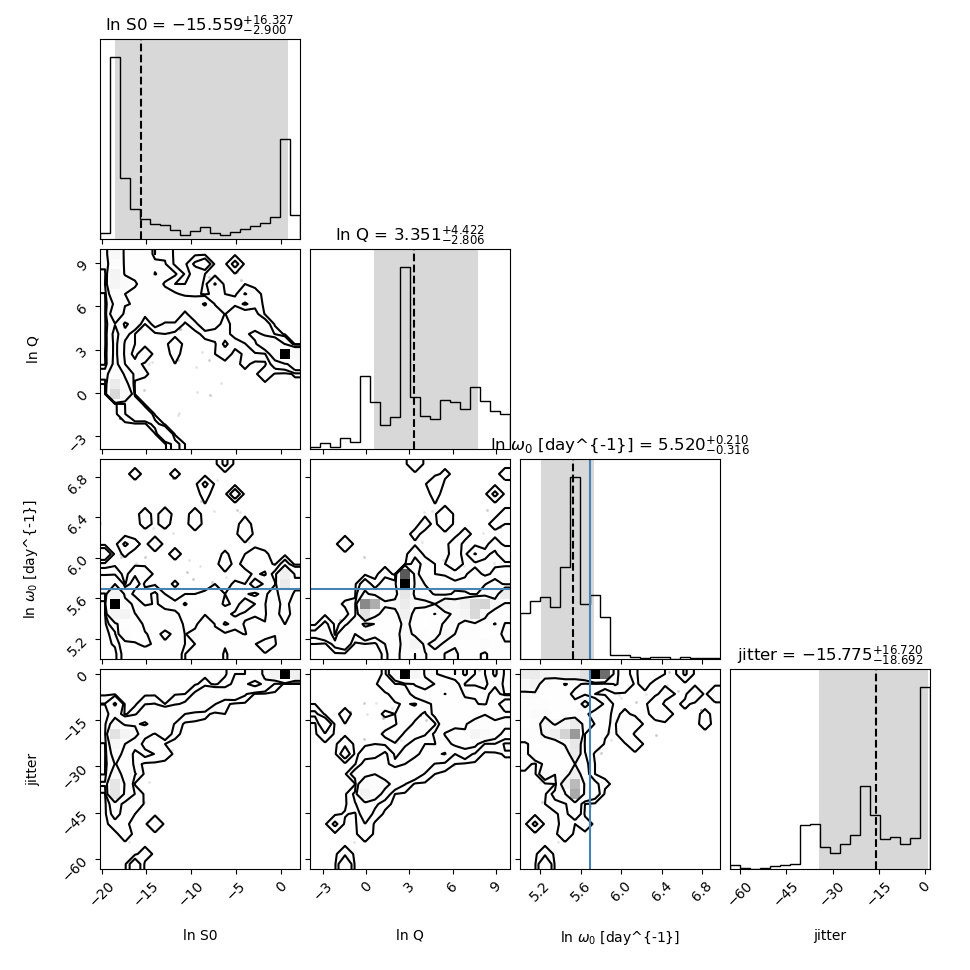

In [25]:
photometry_names = ["TESS_s4","TESS_s5","TESS_s6","TESS_s7","TESS_s32","TESS_s33","TESS_s34","TESS_ALL"]
GP_photometry(photometry_names,normalize=True,initial_params=[1,2.5,5.8,1],mcmc_params=[256,5000,15000]) ### Calculs des posterieurs

In [95]:
photometry_names = ["TESS_s4","TESS_s5","TESS_s6","TESS_s7","TESS_s32","TESS_s33","TESS_s34","TESS_ALL"]
time_binning = 0.15 #en jour pour le binning
periods = np.arange(0.01,100,0.0001) #en jour pour le périodogramme
photometry_periodo_residus(photometry_names,time_binning,periods,normalize=True) ### Résidus + périodogrammes

TESS_ALL


NameError: name 'mean' is not defined

In [ ]:
### Modèle fit multisinus
def modele (time,params) :    
    freqs, ampls = np.loadtxt(par_dir + '/data/TESS_18_19_freqs.txt', usecols=(1, 2)).T ### Récup fréquences et amplitudes de Zieba
    y_th = np.array([])
    for t in time:
        tmp = [] #saves one sine
        for freq, ampl, i in zip(freqs, ampls, range(len(params))):
            tmp = np.append(tmp,(ampl * np.sin(2 * np.pi * freq * t + params['phase_%i'%i] * 2 * np.pi))) ###params['phase_%i'%i] = phase à fitter
        y_th = np.append(y_th,np.sum(tmp))
    y_th = np.power(10,- y_th/2.5) ### Convertit mmag en flux
    return y_th

In [ ]:
### Fonction résidus pour le fit des phases
def residual(params, x, data, eps_data):
    model = modele(x,params)

    return (data-model) / eps_data ### Fonction à minimiser

In [ ]:
photo_data = np.loadtxt(par_dir + "/data/Photometry/TESS_data/TESS_ALL_norm_data.txt",usecols=(0,1,2),skiprows = 1, delimiter = ' ')
time = photo_data[:,0]
flux = photo_data[:,1]
flux_error = photo_data[:,2]
limits = np.array([1437.82566, 1450.20, 1451.547, 1464.40056, 1468.21262, 1477.025, 1478.1, 1490.05, 1491.62553,
                           1503.04, 1504.68, 1516.09, 2174.21898, 2185.94, 2186.938, 2200.23147, 2201.72730, 2213.87, 
                           2215.42, 2227.575, 2228.74533, 2240.91,2241.98, 2254.0676])

In [ ]:
phs = np.loadtxt(par_dir + '/data/TESS_18_19_freqs.txt', usecols=(3)).T ### Récup des phases de Zieba, valeurs initiales dans le fit
params = Parameters() ### Création de l'objet Paramètres

for i in range(len(phs)) :
    params.add('phase_%i'%i, value=phs[i]) ### Pour chaque phase -> un paramètre -> 54 paramètres

for i in range(np.int(len(limits)/2)) :
    print("%.2f - %.2f / %.2f"%(limits[i*2],limits[i*2+1],limits.max()))
    index = np.ndarray.flatten(np.argwhere((time>limits[i*2])&(time<limits[i*2+1]))) ### Fit sur les données secteur par secteur
    time_exp = time[index]
    flux_exp = flux[index]
    flux_error_exp = flux_error[index]
    out = minimize(residual, params, args=(time_exp, flux_exp, flux_error_exp)) ### Fonction lmfit
    for param in out.params.values():
        phs_fit = np.append(phs_fit,param.value) ### Stock des phases fittées
file = open(par_dir + "/data/Photometry/Résidus/fit_phases.txt")
np.savetxt(file,phs_fit) ### Enregistrement phases
file.close()

In [ ]:
phs_fit = np.loadtxt(par_dir + "/data/Photometry/Résidus/fit_phases.txt")

y_fit=np.array([]) ### Valeurs des données trouvées avec le fit
y_res = np.array([]) ### Valeurs des résidus data - fit
for i in range(np.int(len(limits)/2)) :
    print("%.2f - %.2f / %.2f"%(limits[i*2],limits[i*2+1],limits.max()))
    index = np.ndarray.flatten(np.argwhere((time>limits[i*2])&(time<limits[i*2+1]))) ### Sélection du secteur
    time_exp = time[index]
    flux_exp = flux[index]
    freqs, ampls = np.loadtxt(par_dir + '/data/TESS_18_19_freqs.txt', usecols=(1, 2)).T ### Récup fréquences, amplitudes de Zieba
    y = np.array([])
    for t in time_exp: ### Calcul du fit sur le secteur
        tmp = [] #saves one sine
        for freq, ampl, ph in zip(freqs, ampls, phs_fit[i*54:(i+1)*54]): ### 54 phases par secteur
            tmp = np.append(tmp,(ampl * np.sin(2 * np.pi * freq * t + ph * 2 * np.pi)))
        y = np.append(y,np.sum(tmp))
    y = np.power(10,- y/2.5) ### mmag -> flux
    y_fit = np.append(y_fit,y) ### Stockage valeurs fit
    y_res = np.append(y_res,flux[index]-y) ### Calcul du résidus + stockage

file = open(par_dir + "/data/Photometry/Résidus/Résidus_fit_phases.txt")
np.savetxt(file,y_res) ### Enregistrement phases
file.close()